# Тема 'RAG для миграции pyTorch с v1.0.0 на v2.7.0' 

## Настройка для использования

In [ ]:
from logs.logging_setup import configure_logging
configure_logging()
import logging
LOGGER = logging.getLogger(__name__)

from validator import Validator
from retrival import Retreiver, get_embedding_core
from llm import get_llm_response, clean_llm_code
import os
import pandas as pd

LLM_NAME = "tngtech/deepseek-r1t2-chimera"

# =========  Загрузка модели =================
model, tokenizer = get_embedding_core("intfloat/e5-large")
LOGGER.info(f"Модель {model.model_name} загружена")

# =========  Подключение к БД =================
rtr = Retreiver(model, model.model_name)
LOGGER.info(f"БД подключена")

# =========  Инициализация валидатора =================
val = Validator()

def RAG_get_new_code(code, model_name):
    '''
        Получаем новый код после прогана в RAG
    '''
    prompt = rtr.build_prompt(code)
    LOGGER.info(f"Запрос в БД успешно выполнен")

    result = get_llm_response(prompt, model_name=model_name)
    LOGGER.info(f"Запрос в LLM успешно выполнен")

    result_code, explanation = clean_llm_code(result)
    LOGGER.info(f"Получен код из ответа LLM")

    return result_code, explanation





2025-07-27 13:25:18,630 | INFO     | __main__ | Модель intfloat/e5-large загружена
2025-07-27 13:25:22,191 | INFO     | __main__ | БД подключена


## **Что такое RAG и почему он нужен бизнесу**

![Репозитории в gitHub](data\image\more_rag_github.png)

RAG (Retrieval Augmented Generation) — это метод работы с большими языковыми моделями, когда пользователь пишет свой вопросы, а мы программно к этому вопросу «подмешиваете» дополнительную информацию из каких‑то внешних источников и подаём все целиком на вход языковой модели. Другими словами мы говорим, то о чём наша модель может не знать или "забыть" это учесть.

**Давайте разберём на примере:**

*Пользователь*: Какой должен быть шрифт у кода при написании дипломной работы в ОГУ? 

LLM это не знает с вероятностью почти в 100% и тут появляется несколько исходов у LLM.
1) Сказать честно, что она не знает
2) Придумать свой вариант
3) Найти из интернета, но не факт, что она обратится к нужному источнику для поиска информации.

И тут на помощь приходит RAG, он дополняет вопрос пользователя. И поможет LLM ответить правильно.

![Всё хорошо](data\image\all_good.jpg)

## Что он может(на данный момент)?

In [14]:
name = "torch._six"
old_code = """
torch.distributed.init_process_grou": "import torch.distributed as dist; dist.init_process_group(backend='gloo', init_method='tcp://127.0.0.1:12345', world_size=1, rank=0); print('OK')
"""

In [15]:
new_code = RAG_get_new_code(old_code, LLM_NAME)
dict_info, dict_code = val.run_test_old_and_new_code(name, old_code, new_code)

print('='*30)
print('Old code:\n',dict_code['old_code'])
print('='*30)
print('New code:\n',dict_code['new_code'])
print('='*30)

pd.DataFrame(dict_info, index=['Test'])

2025-07-26 16:39:06,515 | INFO     | __main__ | Запрос в БД успешно выполнен
2025-07-26 16:39:50,045 | INFO     | __main__ | Запрос в LLM успешно выполнен
2025-07-26 16:39:50,046 | INFO     | __main__ | Получен код из ответа LLM


Old code:
 
torch.distributed.init_process_grou": "import torch.distributed as dist; dist.init_process_group(backend='gloo', init_method='tcp://127.0.0.1:12345', world_size=1, rank=0); print('OK')

New code:
 import torch.distributed as dist
dist.init_process_group(
    backend='gloo',
    init_method='tcp://127.0.0.1:12345',
    world_size=1,
    rank=0
)
print('OK')


,API,Работает в 1.0.0,Out 1.0.0,Err 1.0.0,Работает в 2.7.0,Out 2.7.0,Err 2.7.0,Работает в 2.7.0 (после RAG),RAG Out 2.7.0,RAG Err 2.7.0
Test,torch._six,False,,"File ""C:\Users\sinde\AppData\Local\Temp\tmpya1...",False,,"File ""C:\Users\sinde\AppData\Local\Temp\tmpetn...",False,OK,[W726 16:40:16.000000000 socket.cpp:755] [c10d...


## Обзор архитектуры

### **Откуда мы брали данные и почему именно эти данные?**

Прежде чем приступать к архитектуре, давайте так же затронем не мало важную тему.

СБОР ДАННЫХ!!


Да, сбор данных это одна из важнейших ступеней в построении хорошей RAG системы. А всё потому что вы можете сделать ЛУЧШУЮ архитектуру, ЛУЧШИЕ методы поиска информации, ЛУЧШАЯ LLM, ЛУЧШИЙ промт, ЛУЧШИЙ UI... Ну ладно UI это конечно лишние.


![image.png](data\image\git_pyTorch.png)

Все данные для создания контекста мы взяли из рилизов опубликованных на [gitHub](https://github.com/pytorch/pytorch/releases)


Они идеально подходят для нашей задачи, так как в рилизах прописываются изменения api, а так же есть примеры написания кода, а так же прописывается номер версии. 

Идеи по улучшению: 
* Можно добавить документацию по каждой из версий. Это даст больший контекст.
* Можно добавить данные из stackOverflou, но их нужно размечать(трудозатратно)



### **Основные компоненты RAG** + (стэк технологий)

Давайте рассмотрим процесс создания RAG целиком, а потом начнём разбирать каждый элемент в отдельности

![RAG](data\image\rag_scheme.png)

Разберём препроцессинг 

![Pre-processing](data\image\rag_scheme_pre_processing.png)

Подготовка данных:

**User Documents:** В нашем случае это рилизы из gitHub

**Далее, chunking:** Я выбрал RecursiveCharacterTextSplitter из LangChain, потому что он предлагает гибкий и семантически осмысленный подход к разбиению текста.python.langchain.com Этот сплиттер рекурсивно делит текст по иерархии разделителей (например, сначала по абзацам, затем по предложениям, словам или символам).

Для embedding я выбрал модель e5-large-v2, которая лидирует в [MTEB leaderboard](https://modal.com/blog/embedding-models-article). 

Почему именно она? 
Эта модель компактна, быстрая в inference, и показывает высокую семантическую схожесть - ключ для RAG, где эмбеддинги должны захватывать нюансы языка. Интегрируется напрямую с LangChain. (Это очень важно для нас, так как подключаемся к БД мы с помощью langChain)

Наконец, хранение эмбеддингов: 
Я использую QDrant в комбинации с LangChain, потому что QDrant - это **AI-native vector database**, оптимизированная для семантического поиска. Интеграция с LangChain проста, через QdrantVectorStore.

Теперь мы перейдём к ретривалу

![Retrieval](data\image\rag_scheme_retrival.png)

Этот модуль - сердце RAG. Отвечает за поиск релевантной информации на основе пользовательского запроса. По сути, он работает как умный поисковик: принимает текст запроса, преобразует его в вектор с помощью той же embedding-модели, и выполняет семантический поиск в базе данных QDrant

Код ниже взят из документации [pyTorch v1.0.0](https://docs.pytorch.org/docs/1.0.0/notes/extending.html?highlight=staticmethod%20def%20forward%20ctx%20input%20weight%20bias%20none%20ctx%20save_for_backward%20input%20weight%20bias)

In [4]:
my_code = """
import torch
from torch.autograd import gradcheck, Function

class LinearFunction(Function):

    
    def forward(ctx, input, weight, bias=None):
        ctx.save_for_backward(input, weight, bias)
        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias


input = (torch.randn(20,20,dtype=torch.double,requires_grad=True), torch.randn(30,20,dtype=torch.double,requires_grad=True))
linear = LinearFunction.apply
test = gradcheck(linear, input, eps=1e-6, atol=1e-4)
print(test)

"""
documents = rtr._get_retriever_for_langChain(k=6).invoke(my_code)

In [5]:
documents

[Document(metadata={'version': 'v1.2.0', 'release_name': 'New TorchScript API with Improved Python Language Coverage, Expanded ONNX Export, NN.Transformer', 'chunk_id': 'v1.2.0-51', '_id': '3dbcc1bb-db5a-46d9-b2a2-253a4aacd2ea', '_collection_name': 'migTorch_test_intfloat_e5-large'}, page_content="is now deprecated, please use 'out' parameter with dtype torch.bool instead.\r\n\r\ntensor([0, 1, 1], dtype=torch.uint8)\r\n\r\n# instead use torch.bool\r\n>>> res = torch.empty_like(a, dtype=torch.bool)\r\n>>> torch.gt(a, b, out=res)\r\ntensor([False, True, True])\r\n```\r\n\r\n\r\n\r\n### Legacy `autograd.Function` (Function without static forward method) is now deprecated\r\n\r\n```\r\n>>> class MyLegacyFunction(Function):\r\n>>>     def forward(self, x):\r\n>>>         return x\r\n>>>\r\n>>>     def backward(self, grad_output):\r\n>>>         return grad_output\r\n>>>\r\n>>> MyLegacyFunction()(torch.randn((3,), requires_grad=True)\r\nUserWarning: Legacy autograd function with non-static f

Что выдал нам retrival?

* v 1.2.0 - говорится, что стоит использовать ```@staticmethod``` перед методами нашей кастомной автоградиентной функцией.

* v 1.5.0 - затрагивается ```output = input.mm(weight.t())``` из ```LinearFunction.forward()```  говорится, что лучше клонировать наш вход и работать с клонами. В нашем случае мы именно так и делаем.

* v 1.7.0 - изменение поведения градиента ctx.needs_input_grad выводил None, теперь выводит zero.

* v 1.13.0 - информация о низкоуровневых изменениях вычисления градиента



Конеченый этап

![Retrieval](data\image\rag_scheme_response.png)

Тут остаётся самое лёгкое, формируется запрос путём подставления изначально запроса и релевантного контекста, о котором нам говорит наш ретривал.

Вот так выглядит наш промт

In [ ]:
"""
You are a senior PyTorch engineer helping migrate code from v1.0 to v2.7.

### Original code (v1.0)
```python
{old_code}
```

### Context (docs & changelog)
{context}

### Task
Rewrite the code so it runs on **PyTorch 2.7**. Explain what you changed.

### Answer format
First, provide the updated code in the following format:
```python
import torch
# updated code here
```
Then, after the code block, provide a detailed explanation as a single continuous paragraph of text describing the changes you made and the reasons for each change.

"""

## Практика и метрики

### Метрики

Метрики при наличии 21 теста с вариантами, когда есть рабочий и не рабочий код.

In [1]:
import pandas as pd
import glob

In [ ]:

def analyz_test():
    csv_files = glob.glob("*.csv", root_dir="data/")

    results = []

    for csv_file in csv_files:
        dfTest = pd.read_csv("data/"+csv_file)
        сount_test = len(dfTest)

        count_works_1_0 = dfTest['Is work in 1.0.0'].sum()
        count_works_2_7 = dfTest['Is work in 2.7.0'].sum()
        count_rag_2_7 = dfTest['Is work in 2.7.0 (после RAG)'].sum()

        pct_works_1_0 = (count_works_1_0 / сount_test) * 100
        pct_works_2_7 = (count_works_2_7 / сount_test) * 100
        pct_rag_2_7 = (count_rag_2_7 / сount_test) * 100

        result_dict = {
            "Is work in 1.0.0": count_works_1_0,
            "Is work in 1.0.0 (%)": pct_works_1_0,
            "Is work in 2.7.0": count_works_2_7,
            "Is work in 2.7.0 (%)": pct_works_2_7,
            "Is work in 2.7.0 (RAG)": count_rag_2_7,
            "Is work in 2.7.0 (RAG) (%)": pct_rag_2_7,
        }

        results.append(result_dict)
    
    return pd.DataFrame(results, index=csv_files)

analyz_test()

,Is work in 1.0.0,Is work in 1.0.0 (%),Is work in 2.7.0,Is work in 2.7.0 (%),Is work in 2.7.0 (RAG),Is work in 2.7.0 (RAG) (%)
BAAI_bge-base-en.csv,10,52.631579,6,31.578947,14,73.684211
BAAI_bge-large-en.csv,10,52.631579,6,31.578947,15,78.947368
intfloat_e5-large.csv,10,52.631579,6,31.578947,16,84.210526
sentence-transformers_all-MiniLM-L6-v2.csv,10,52.631579,6,31.578947,17,89.473684
sentence-transformers_LaBSE.csv,10,52.631579,6,31.578947,16,84.210526


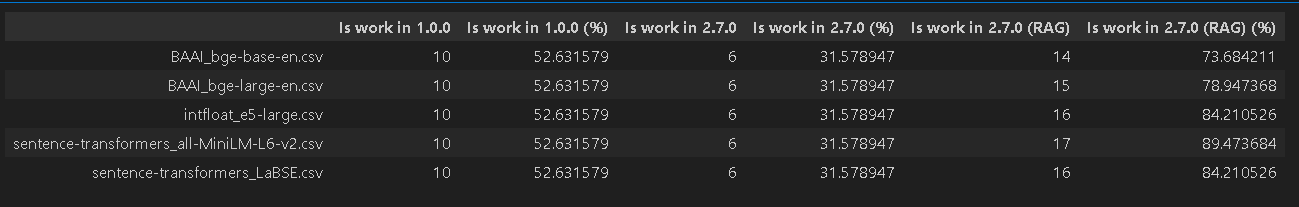

Метрика при наличии 9 тестов, которые работают в v1.0.0

In [1]:
import pandas as pd
import glob

def analyz_test():
    csv_files = glob.glob("*.csv", root_dir="data/")

    results = []

    for csv_file in csv_files:
        dfTest = pd.read_csv("data/"+csv_file)
        сount_test = len(dfTest)

        count_works_1_0 = dfTest['Is work in 1.0.0'].sum()
        count_works_2_7 = dfTest['Is work in 2.7.0'].sum()
        count_rag_2_7 = dfTest['Is work in 2.7.0 (после RAG)'].sum()

        pct_works_1_0 = (count_works_1_0 / сount_test) * 100
        pct_works_2_7 = (count_works_2_7 / сount_test) * 100
        pct_rag_2_7 = (count_rag_2_7 / сount_test) * 100

        result_dict = {
            "Is work in 1.0.0": count_works_1_0,
            "Is work in 1.0.0 (%)": pct_works_1_0,
            "Is work in 2.7.0": count_works_2_7,
            "Is work in 2.7.0 (%)": pct_works_2_7,
            "Is work in 2.7.0 (RAG)": count_rag_2_7,
            "Is work in 2.7.0 (RAG) (%)": pct_rag_2_7,
        }

        results.append(result_dict)
    
    return pd.DataFrame(results, index=csv_files)

analyz_test()

,Is work in 1.0.0,Is work in 1.0.0 (%),Is work in 2.7.0,Is work in 2.7.0 (%),Is work in 2.7.0 (RAG),Is work in 2.7.0 (RAG) (%)
BAAI_bge-base-en.csv,9,100.0,1,11.111111,8,88.888889
BAAI_bge-large-en.csv,9,100.0,1,11.111111,8,88.888889
intfloat_e5-large.csv,9,100.0,1,11.111111,7,77.777778
sentence-transformers_all-MiniLM-L6-v2.csv,9,100.0,1,11.111111,8,88.888889
sentence-transformers_LaBSE.csv,9,100.0,1,11.111111,8,88.888889
